In [57]:
import numpy as np
import pandas as pd
import cpmpy as cp
from cctbx.sgtbx.direct_space_asu.reference_table import get_asu
from pyxtal import Group, Wyckoff_position
import rho_plus as rp

rp.plotly_setup(True)
theme, cs = rp.mpl_setup(True)

In [97]:
sg = Group(179)
asu = get_asu(sg.number)
asu.show_comprehensive_summary()

Hall symbol: P 65 2 (0 0 1)
Number of cuts: 6
    & x0
    & +x1
    & y0
    & +y1
    & z0(p0)
    & z12(m1 & x0(-y0))


In [99]:
import plotly.express as px
from baysic.feature_space import FeatureSpace

fs = FeatureSpace(sg.number)

xyz_u = np.mgrid[0:1:12j, 0:1:12j, 0:1:12j].reshape(3, -1).T

xyz = fs.to_general_positions(xyz_u)
xx, yy, zz = xyz.T

fig = px.scatter_3d(x=xx, y=yy, z=zz)
fig.update_traces(marker=dict(size=2))

In [100]:
from tqdm import trange
xyz_u = np.mgrid[0.01:0.99:12j, 0.01:0.99:12j, 0.01:0.99:12j].reshape(3, -1).T
cc = np.zeros_like(xyz_u[:, [0]])

for group in range(1, 231):
    fs = FeatureSpace(group)    

    xyz = fs.to_general_positions(xyz_u)
    xx, yy, zz = xyz.T
    wp = fs.sg.Wyckoff_positions[0]
    mats = np.stack([op.affine_matrix for op in wp.ops], axis=0)
    
    xyzc = np.hstack([xyz, cc])

    pts = (mats @ xyzc.T).swapaxes(1, 2)[:, :, :3]
    
    if not np.all(np.ptp(pts, axis=1) <= 1):
        print('WPs span lattice cells: ', fs.sg.symbol)

    # diffs = pts[1:] - pts[0]
    # if not np.all(np.ptp(diffs, axis=1) <= 1):    
    #     print('WP distances span lattice cells: ', fs.sg.symbol)

WPs span lattice cells:  P31
WPs span lattice cells:  P32
WPs span lattice cells:  P3112
WPs span lattice cells:  P3121
WPs span lattice cells:  P3212
WPs span lattice cells:  P3221
WPs span lattice cells:  P61
WPs span lattice cells:  P65
WPs span lattice cells:  P6122
WPs span lattice cells:  P6522


In [101]:
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius

# thresh = 2 * CovalentRadius.radius['Sn'] / np.sqrt(3) / lat_scale
# thresh = 0.08

fs = FeatureSpace(214)    

xyz = fs.to_general_positions(xyz_u)
xx, yy, zz = xyz.T
wp = fs.sg.Wyckoff_positions[0]
mats = np.stack([op.affine_matrix for op in wp.ops], axis=0)

xyzc = np.hstack([xyz, cc])

pts = (mats @ xyzc.T).swapaxes(1, 2)[:, :, :3]

In [102]:
lcms = set()
for g in range(1, 231):
    asu = get_asu(g)    
    lcms.update({c.lcm_of_denominators() for c in asu.cuts})

lcms

{1, 2, 3, 4, 6, 8, 12}

In [103]:
import cpmpy as cp

fs = FeatureSpace(214)

ndiffs_d = 12
nvar_d = 24 * 3
nd = ndiffs_d * nvar_d

xyz = []
lows = np.array(fs.asu.box_min()) * nvar_d
highs = np.array(fs.asu.box_max()) * nvar_d
for ax, lo, hi in zip('xyz', lows, highs):    
    xyz.append(cp.intvar(int(lo), int(hi), name=ax))

xyz = cp.cpm_array(xyz)

thresh = 0.1
int_thresh = int(round(thresh * nd))

diffs = mats[1:] - mats[0]
# affine matrices don't use the bottom corner to add/subtract
diffs += np.diag([0, 0, 0, 1])
diffs_int = (diffs * ndiffs_d).astype(int)

xyzc = np.hstack([xyz, nvar_d])

dists = (diffs_int @ xyzc)[:, :3]

constrs = []
for d in dists:
    d = d % (nd + 1)
    d = (nd // 2) - np.abs(d - nd // 2)
    constrs.append(cp.sum(d) >= int_thresh)

mod = cp.Model()
for i, constr in enumerate(constrs):
    mod += [constr]
    # if not mod.solve('z3'):
    #     print(constr)
    #     print(i)
    #     break

# mod.solve('z3')
constrs[:5]

[sum([432, -(abs((((sum([-24, 0, 0] * [x, y, z])) + 432) mod 865) + -432)), 432 + (-(abs(((sum([0, -24, 0] * [x, y, z])) mod 865) + -432))), 432, -(abs((((sum([0, 0, 0] * [x, y, z])) + 432) mod 865) + -432))]) >= 86,
 sum([432, -(abs(((sum([-24, 0, 0] * [x, y, z])) mod 865) + -432)), 432 + (-(abs((((sum([0, 0, 0] * [x, y, z])) + 432) mod 865) + -432))), 432, -(abs((((sum([0, 0, -24] * [x, y, z])) + 432) mod 865) + -432))]) >= 86,
 sum([432, -(abs((((sum([0, 0, 0] * [x, y, z])) + 432) mod 865) + -432)), 432 + (-(abs((((sum([0, -24, 0] * [x, y, z])) + 432) mod 865) + -432))), 432, -(abs(((sum([0, 0, -24] * [x, y, z])) mod 865) + -432))]) >= 86,
 sum([432, -(abs(((sum([-12, 0, 12] * [x, y, z])) mod 865) + -432)), 432 + (-(abs(((sum([12, -12, 0] * [x, y, z])) mod 865) + -432))), 432, -(abs(((sum([0, 12, -12] * [x, y, z])) mod 865) + -432))]) >= 86,
 sum([432, -(abs((((sum([-12, 0, 12] * [x, y, z])) + 432) mod 865) + -432)), 432 + (-(abs((((sum([-12, -12, 0] * [x, y, z])) + 432) mod 865) + 

In [104]:
sols = []

def process():
    vals = xyz.value() / nvar_d
    sols.append(vals)
    print('{:.3f}\t{:.3f}\t{:.3f}'.format(*vals))

mod.solveAll('z3', display=process, solution_limit=10, time_limit=15)

sols = np.array(sols)

0.014	0.000	0.306


In [109]:
import plotly.express as px
from baysic.feature_space import FeatureSpace

fs = FeatureSpace(sg.number)

xyz_u = np.mgrid[0:1:12j, 0:1:12j, 0:1:12j].reshape(3, -1).T

xyz = fs.to_general_positions(xyz_u)
xx, yy, zz = xyz.T

In [112]:
import itertools
from scipy.spatial.distance import pdist
wp = sg.Wyckoff_positions[0]

def get_dists(xyz):
    pos = []
    for op in wp.ops:
        pts = op.operate_multi(xyz)
        pos.append(pts)
        

    pos = np.stack(pos, axis=1)

    dists = []
    for i in range(pos.shape[0]):
        vecs = pos[i, 1:] - pos[i, 0]
        vecs_mod1 = vecs % 1
        vecs_mod1 = np.where(vecs_mod1 >= 0.5, -vecs_mod1, vecs_mod1)
        dists.append(np.sqrt(np.square(vecs_mod1).sum(axis=1)))


    dists = np.stack(dists)
    return (pos, dists)


xyz_pos, xyz_dists = get_dists(xyz)
cpm_pos, cpm_dists = get_dists(np.array(sols))

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Probability'>

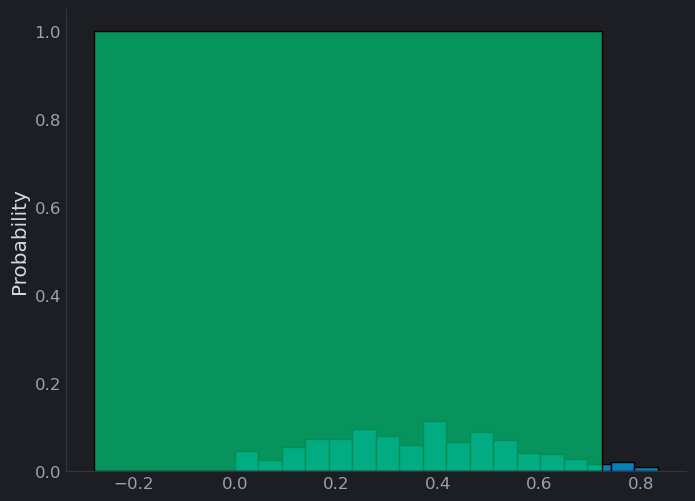

In [113]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(xyz_dists.min(axis=1), stat='probability')
sns.histplot(cpm_dists.min(axis=1), stat='probability')

In [114]:
import plotly.graph_objects as go
fig = px.scatter_3d(x=xx, y=yy, z=zz, color=xyz_dists.min(axis=1))
fig.add_trace(go.Scatter3d(x=sols[:, 0], y=sols[:, 1], z=sols[:, 2]))
fig.update_traces(marker=dict(size=2))

In [116]:
mask = xyz[:, 2] == 0.1
true = xyz_dists.min(axis=1)

fig = px.scatter_3d(x=xx[mask], y=yy[mask], z=true[mask])
fig.add_trace(go.Mesh3d(x=xx[mask], y=yy[mask], z=true[mask], alphahull=0, flatshading=True))
fig

In [117]:
from scipy import interpolate as interp

smaller_xyz_u = np.mgrid[0:1:11j, 0:1:11j, 0:1:11j].reshape(3, -1).T

smaller_xyz = fs.to_general_positions(smaller_xyz_u)
small_pos, small_dists = get_dists(smaller_xyz)

spl = interp.LinearNDInterpolator(smaller_xyz, small_dists.min(axis=1))

true = xyz_dists.min(axis=1)
yhat = spl(xyz)
err = true - yhat

# fig = px.scatter_3d(x=xx, y=yy, z=zz, color=err, color_continuous_scale='icefire', color_continuous_midpoint=0, opacity=0.5)
mask = true > 0.2
xx_u, yy_u, zz_u = xyz_u[mask].T
fig = px.scatter_3d(x=xx_u, y=yy_u, z=zz_u, color=true[mask], color_continuous_scale='agsunset')
fig.update_traces(marker=dict(size=2))
# fig.add_trace(go.Scatter3d(x=smaller_xyz[:, 0], y=smaller_xyz[:, 1], z=smaller_xyz[:, 2], marker=dict(size=5, color='black'), mode='markers'))
fig

In [ ]:
# spaces = np.arange(7, 22, 2)
# true = xyz_dists.min(axis=1)
# errs = []
# for space in spaces:
#     sj = space * 1j
#     eps = 0
#     lo = -eps
#     hi = 1 + eps
#     smaller_xyz_u = np.mgrid[lo:hi:sj, lo:hi:sj, lo:hi:sj].reshape(3, -1).T

#     smaller_xyz = fs.to_general_positions(smaller_xyz_u)
#     small_pos, small_dists = get_dists(smaller_xyz)

#     yhat = interp.interpn(
#         [np.mgrid[lo:hi:sj] for _ in range(3)],
#         small_dists.min(axis=1).reshape(space, space, space),
#         xyz_u,
#         method='pchip'
#     )
        
#     err = true - yhat 
#     nanmask = np.where(np.isnan(err))
#     errs.append(np.nan_to_num(err, 0))

# errs = np.array(errs)

# qs = np.quantile(errs, np.linspace(0, 1, 20), axis=1)
# for color, q in zip(sns.color_palette('viridis', qs.shape[0]), qs):
#     plt.plot(spaces, q, color=color)

# plt.ylim(-0.3, 0.3)

In [ ]:
# from sympy import *

# x, y, z = symbols('x y z', real=True)
# xyz = np.array([[x, y, z]])

# pos = []
# for op in wp.ops:
#     pts = op.operate_multi(xyz)
#     pos.append(pts)
    

# pos = np.stack(pos, axis=1)

# dists = []
# for i in range(pos.shape[0]):
#     vecs = pos[i, 1:] - pos[i, 0]
#     # distances mod 1: get closest pair modulo lattice
#     vecs_mod1 = vecs
#     vecs_mod1 = 0.5 - abs(vecs_mod1 - 0.5)
#     dists.append(np.square(vecs_mod1).sum(axis=1))


# dists = np.stack(dists)[0]
# exp_dists = [exp(x) for x in dists]
# min_dist = sum([dist * exp(dist) for dist in dists])
# min_dist /= sum(exp_dists)
# min_dist

((4.0*(0.25 - Abs(x))**2 + (0.5 - Abs(2.0*z - 0.5))**2)*exp(4.0*(0.25 - Abs(x))**2 + (0.5 - Abs(2.0*z - 0.5))**2) + (4.0*(0.25 - Abs(y))**2 + (0.5 - Abs(2.0*x - 0.5))**2)*exp(4.0*(0.25 - Abs(y))**2 + (0.5 - Abs(2.0*x - 0.5))**2) + (4.0*(0.25 - Abs(z))**2 + (0.5 - Abs(2.0*y - 0.5))**2)*exp(4.0*(0.25 - Abs(z))**2 + (0.5 - Abs(2.0*y - 0.5))**2) + ((0.5 - Abs(2.0*x - 0.75))**2 + 2*(0.5 - Abs(1.0*y + 1.0*z - 0.75))**2)*exp((0.5 - Abs(2.0*x - 0.75))**2 + 2*(0.5 - Abs(1.0*y + 1.0*z - 0.75))**2) + ((0.5 - Abs(2.0*x - 0.25))**2 + 2*(0.5 - Abs(1.0*y + 1.0*z - 0.25))**2)*exp((0.5 - Abs(2.0*x - 0.25))**2 + 2*(0.5 - Abs(1.0*y + 1.0*z - 0.25))**2) + ((0.5 - Abs(2.0*x + 0.25))**2 + 2*(0.5 - Abs(-1.0*y + 1.0*z + 0.25))**2)*exp((0.5 - Abs(2.0*x + 0.25))**2 + 2*(0.5 - Abs(-1.0*y + 1.0*z + 0.25))**2) + ((0.5 - Abs(2.0*y - 0.75))**2 + 2*(0.5 - Abs(1.0*x + 1.0*z - 0.75))**2)*exp((0.5 - Abs(2.0*y - 0.75))**2 + 2*(0.5 - Abs(1.0*x + 1.0*z - 0.75))**2) + ((0.5 - Abs(2.0*y - 0.25))**2 + 2*(0.5 - Abs(1.0*x + 1.0